In [ ]:
#Import all the necessary packages
import pandas as pd
from gensim import corpora, models, similarities
import gensim
import numpy as np
import pickle
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


In [ ]:
df = pd.read_csv('df_grouped.csv')

In [3]:
df

,asin,reviewText,count
0,B00FLYWNYQ,I was excited to try this so as soon as I got ...,7433
1,B00COK3FD8,The tupperware was exactly as described. I lov...,4563
2,B009HVH4XO,i have 4 of these and i didn't think they coul...,4460
3,B00NX47YP4,Pros:\nSeems to weigh accurately\nEasy to use ...,4379
4,B00902X68W,I love these sheets. They are so soft and coz...,3725
...,...,...,...
188133,B00176NOZO,I'm not sure if the one I received was defecti...,1
188134,B00KLFM0ZW,They are really nice quality and they look rea...,1
188135,B00FYHDHT0,Luxury look at a reasonable price. Very elega...,1
188136,B01D1AI06Q,Good luck cutting anything with this junk. Nic...,1


In [4]:
#Load model
lda_model = models.LdaModel.load('LDA_Model_grp_7_15.lda')

In [5]:
#Load corpus
corpus = corpora.MmCorpus('amzn_h_k_review.mm')

In [51]:
#Load Dictionary
texts_dict_unq =  corpora.Dictionary.load('auto_review_unq.dict')

In [7]:
#To load texts (tokenized)
with open('texts.pkl', 'rb') as f:
    texts = pickle.load(f)

In [8]:
#To find the most representing topic for each item
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [9]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [10]:
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","[excited, soon, followed, manual, setting, bro..."
1,1,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","[tupperware, exactly, described, love, rubberm..."
2,2,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","[think, better, easy, clean, verify, rinsed, i..."
3,3,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","[pro, seems, weigh, accurately, easy, button, ..."
4,4,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","[love, sheet, soft, cozy, problem, pilling, wa..."
5,5,2.0,0.6996,"chair, mattress, comfortable, wine, bottle, pi...","[received, pillow, today, pillow, although, ap..."
6,6,4.0,0.6021,"pillow, sheet, vacuum, blanket, fabric, towel,...","[another, single, tank, stay, turned, extreme,..."
7,7,4.0,0.5815,"pillow, sheet, vacuum, blanket, fabric, towel,...","[wish, something, compare, bought, review, lov..."
8,8,0.0,0.8238,"coffee, bowl, container, drink, cup, food, mac...","[thermos, best, opened, found, still, thermos,..."
9,9,0.0,0.8185,"coffee, bowl, container, drink, cup, food, mac...","[update, still, original, hello, kitty, blue, ..."


In [11]:
#Merge dataframe to get item id
df_merged = pd.concat([df['asin'], df_dominant_topic], axis=1, sort=False)

In [12]:
df_merged.set_index('Document_No',inplace = True)

In [13]:
df_merged

,asin,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,,
0,B00FLYWNYQ,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","[excited, soon, followed, manual, setting, bro..."
1,B00COK3FD8,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","[tupperware, exactly, described, love, rubberm..."
2,B009HVH4XO,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","[think, better, easy, clean, verify, rinsed, i..."
3,B00NX47YP4,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","[pro, seems, weigh, accurately, easy, button, ..."
4,B00902X68W,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","[love, sheet, soft, cozy, problem, pilling, wa..."
...,...,...,...,...,...
188133,B00176NOZO,5.0,0.6188,"candle, clock, unit, smell, filter, battery, s...","[sure, received, defective, hold, temperature,..."
188134,B00KLFM0ZW,4.0,0.8135,"pillow, sheet, vacuum, blanket, fabric, towel,...","[really, nice, quality, look, really, good, wa..."
188135,B00FYHDHT0,4.0,0.9548,"pillow, sheet, vacuum, blanket, fabric, towel,...","[luxury, look, reasonable, price, elegant, see..."


In [18]:
#Save for later use
df_merged.to_csv('df_topic.csv',index=False)

In [ ]:
#load merged data
#df_merged = pd.read_csv('df_topic.csv')

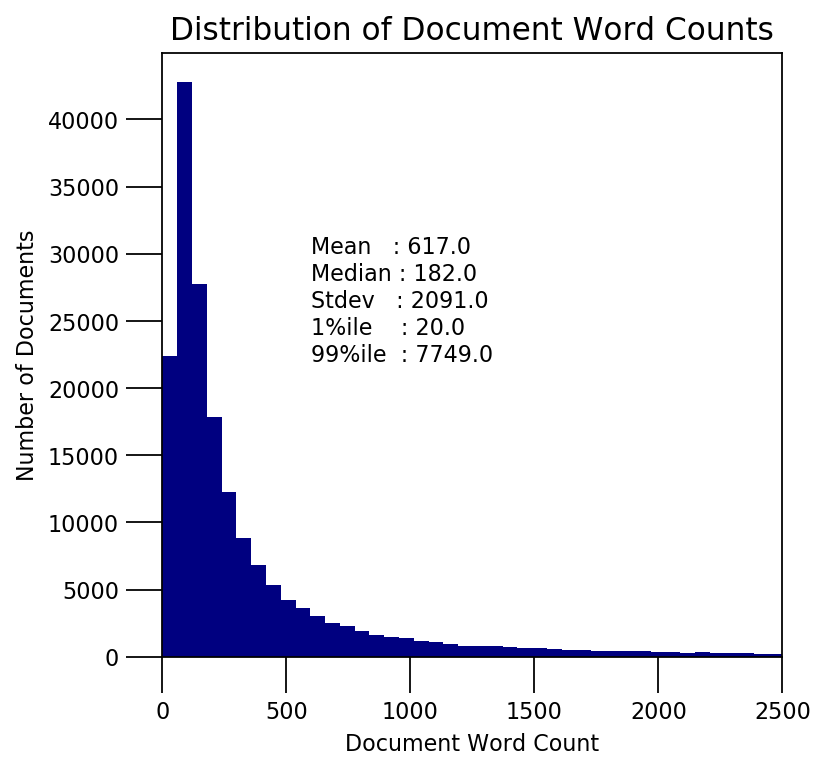

In [14]:
#Plot distribution of document word counts
doc_lens = [len(d) for d in df_merged.Text]
# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 4000, color='navy')
plt.text(600, 30000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(600, 28000, "Median : " + str(round(np.median(doc_lens))))
plt.text(600, 26000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(600, 24000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(600, 22000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 2500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=14))
plt.show()

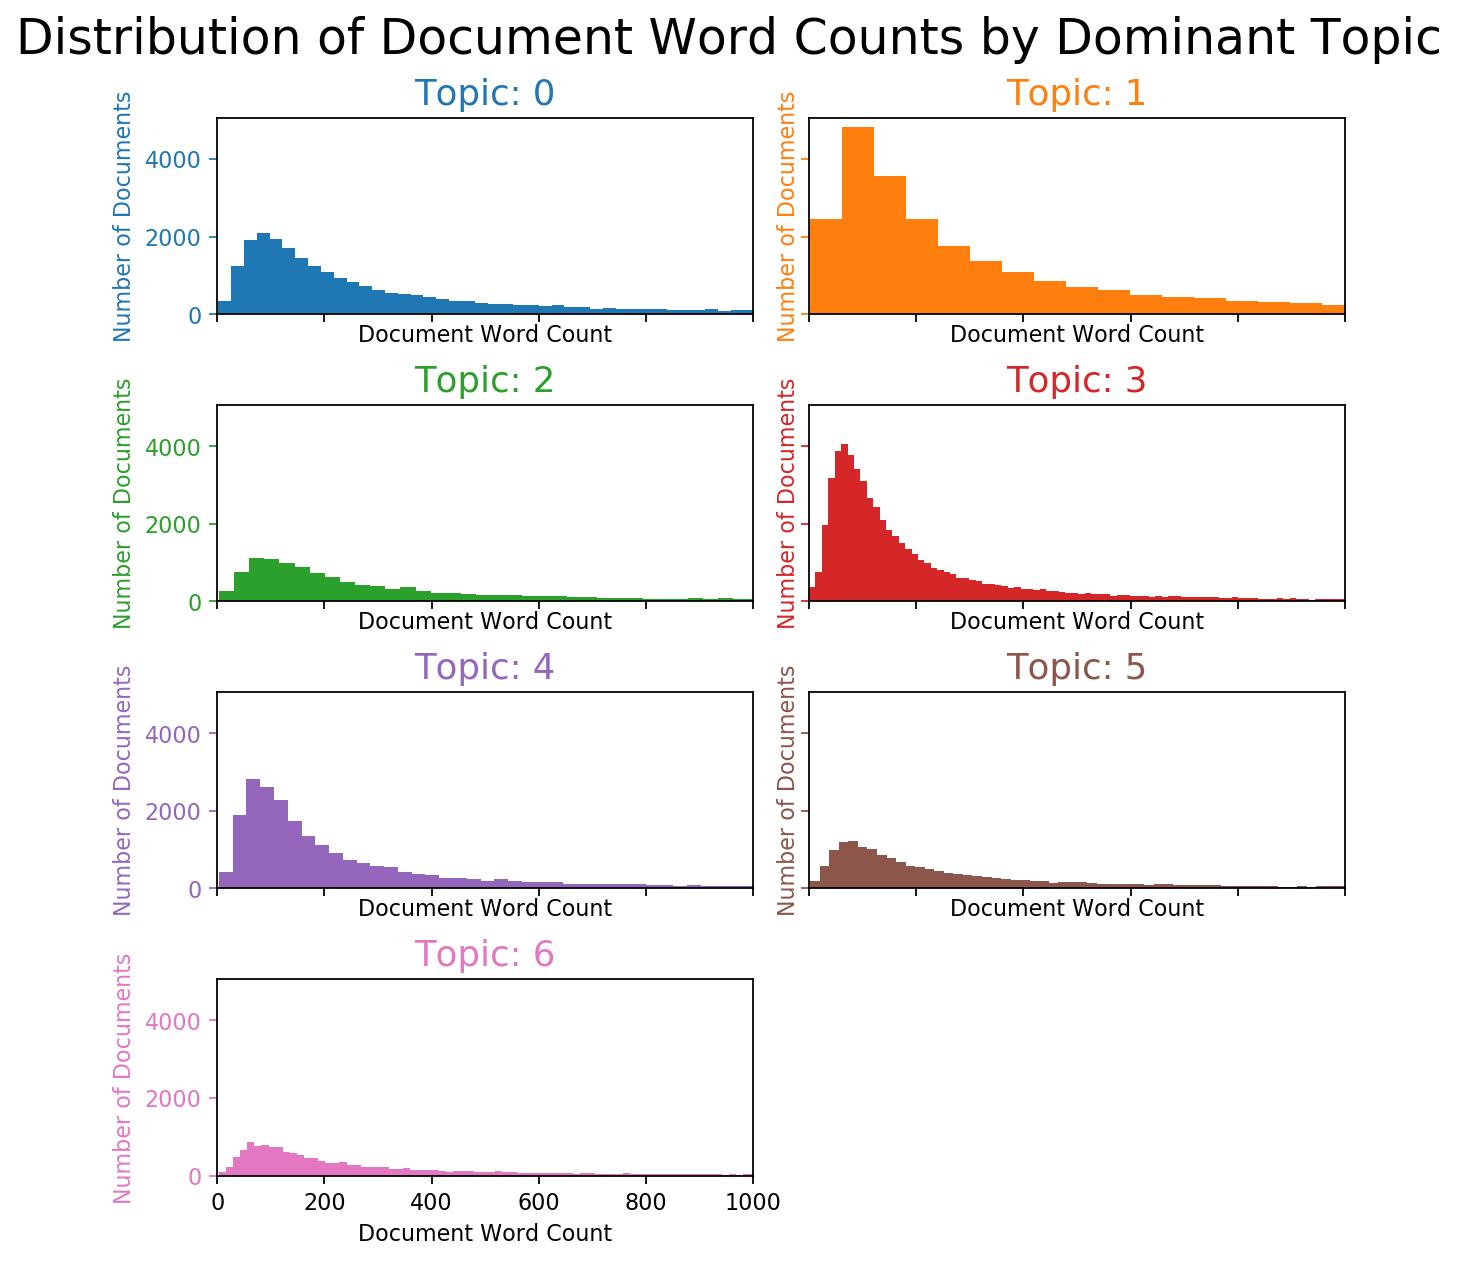

In [15]:
#Plot distribution of document word counts by dominant topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
fig, axes = plt.subplots(4,2,figsize=(8,8), dpi=160, sharex=True, sharey=True)
fig.delaxes(axes[3,1]) 
for i, ax in enumerate(axes.flatten()):  
    if(i<7):
        df_dominant_topic_sub = df_merged.loc[df_merged.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins = 4000, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        ax.set(xlim=(0, 1000), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [16]:
#create a merged list of stop words
nltk_stpwd = stopwords.words('english')
#Extend stopwords with commonly found tokens in review texts
nltk_stpwd.extend(['generally', 'used', 'personally', 'review', 'honestly','truly','whatever','done','star','one','two','three','four','five','since','ever','even','much','thing','also','go','come','must'])
stop_words_stpwd = get_stop_words('en')
stop_words = list(set(nltk_stpwd + stop_words_stpwd))

print(len(set(stop_words)))
print(stop_words[:10])

234
['three', "mightn't", 'me', 'having', 'review', "we've", 'and', 'nor', "hadn't", 'am']


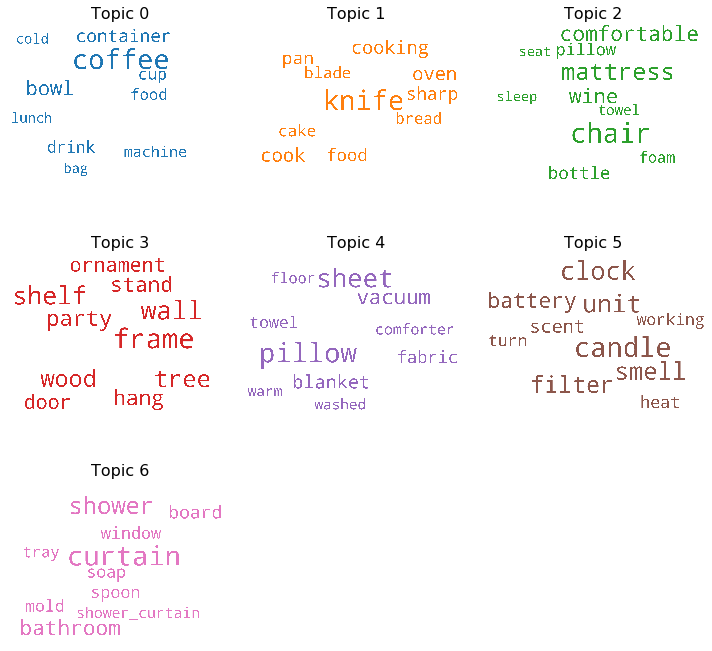

In [17]:
# 1. Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
fig.delaxes(axes[2,1]) 
fig.delaxes(axes[2,2]) 
for i, ax in enumerate(axes.flatten()):
    if(i<7):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Gensim Similarity: https://radimrehurek.com/gensim/similarities/docsim.html

In [19]:
#Cosine similarity measures between bag of words vectors give us similarities in the range of -1 to 1 (the greater, the more similar)
index = similarities.MatrixSimilarity(lda_model[corpus])

In [20]:
#Save similarity pickle file for later use
with open('index.pkl', 'wb') as f:
    pickle.dump(index, f)

In [ ]:
#load similarity pickle file
#with open('index.pkl', 'rb') as f:
    #index = pickle.load(f)

In [21]:
#Find of which topic each document is composed os
corpus_lda_model = lda_model[corpus]

In [135]:
Title_prod = pd.read_pickle('Title_prod')

In [136]:
df_final = df_merged.join(Title_prod.set_index('asin'), on='asin')

In [137]:
df_final

,asin,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,title
Document_No,,,,,,
0,B00FLYWNYQ,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","[excited, soon, followed, manual, setting, bro...",Instant Pot DUO60 6 Qt 7-in-1 Multi-Use Progra...
1,B00COK3FD8,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","[tupperware, exactly, described, love, rubberm...",Rubbermaid Easy Find Lids Food Storage Contain...
2,B009HVH4XO,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","[think, better, easy, clean, verify, rinsed, i...",Contigo AUTOSEAL West Loop Vacuum-Insulated St...
3,B00NX47YP4,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","[pro, seems, weigh, accurately, easy, button, ...",Ozeri ZK14-R Pronto Digital Multifunction Kitc...
4,B00902X68W,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","[love, sheet, soft, cozy, problem, pilling, wa...",Clara Clark 1800 Premier Series 4pc Bed Sheet ...
...,...,...,...,...,...,...
188133,B00176NOZO,5.0,0.6188,"candle, clock, unit, smell, filter, battery, s...","[sure, received, defective, hold, temperature,...",var aPageStart = (new Date()).getTime();\nvar ...
188134,B00KLFM0ZW,4.0,0.8135,"pillow, sheet, vacuum, blanket, fabric, towel,...","[really, nice, quality, look, really, good, wa...",Cuisinart 100% Cotton Terry Super Absorbent Ki...
188135,B00FYHDHT0,4.0,0.9548,"pillow, sheet, vacuum, blanket, fabric, towel,...","[luxury, look, reasonable, price, elegant, see...",Lenox 844724 Sharon Sacks Jeweled Jardin 5-Pie...


In [138]:
df_final.drop_duplicates(subset = ['asin'],inplace = True)

In [139]:
df_final

,asin,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,title
Document_No,,,,,,
0,B00FLYWNYQ,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","[excited, soon, followed, manual, setting, bro...",Instant Pot DUO60 6 Qt 7-in-1 Multi-Use Progra...
1,B00COK3FD8,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","[tupperware, exactly, described, love, rubberm...",Rubbermaid Easy Find Lids Food Storage Contain...
2,B009HVH4XO,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","[think, better, easy, clean, verify, rinsed, i...",Contigo AUTOSEAL West Loop Vacuum-Insulated St...
3,B00NX47YP4,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","[pro, seems, weigh, accurately, easy, button, ...",Ozeri ZK14-R Pronto Digital Multifunction Kitc...
4,B00902X68W,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","[love, sheet, soft, cozy, problem, pilling, wa...",Clara Clark 1800 Premier Series 4pc Bed Sheet ...
...,...,...,...,...,...,...
188133,B00176NOZO,5.0,0.6188,"candle, clock, unit, smell, filter, battery, s...","[sure, received, defective, hold, temperature,...",var aPageStart = (new Date()).getTime();\nvar ...
188134,B00KLFM0ZW,4.0,0.8135,"pillow, sheet, vacuum, blanket, fabric, towel,...","[really, nice, quality, look, really, good, wa...",Cuisinart 100% Cotton Terry Super Absorbent Ki...
188135,B00FYHDHT0,4.0,0.9548,"pillow, sheet, vacuum, blanket, fabric, towel,...","[luxury, look, reasonable, price, elegant, see...",Lenox 844724 Sharon Sacks Jeweled Jardin 5-Pie...


## Let's make some recommendations!

In [175]:
#Define recommender function
def Product_recommender(asin):
    prd_checked = 0
    for i in range(len(df_final)):
        recommendation_scores = []
        if df_final.asin[i] == asin:
            lda_vectors = corpus_lda_model[i]

            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                item_num = sim[0]
                recommendation_score = [df_final.title[item_num], sim[1]]
                recommendation_scores.append(recommendation_score)
                
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
            
            print("Your item's most prominant topic is:")
            print(lda_model.print_topic(max(lda_vectors, key=lambda item: item[-1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(df_final.title[i]))
            display(recommendation[1:6])
        
        else:
            prd_checked +=1
            
        if prd_checked == len(df_final):
            print('Sorry, but it looks like "{}" is not available.'.format(asin))

In [176]:
Product_recommender('B00COK3FD8')

Your item's most prominant topic is:
0.024*"coffee" + 0.012*"bowl" + 0.009*"container" + 0.007*"drink" + 0.007*"cup" + 0.007*"food" + 0.006*"machine" + 0.005*"cold" + 0.005*"lunch" + 0.005*"bag"
-----
Here are your recommendations for "Rubbermaid Easy Find Lids Food Storage Containers, Racer Red, 42-Piece Set 1880801":


[['Classic 28 oz. Unbreakable Polycarbonate Jumbo Cooler', 0.99999994],
 ['Wine Enthusiast Steady-Temp Double Wall Beer Glasses, Set of 2',
  0.99999994],
 ['Set of 4 - 16-oz Clear Glass Mason Jar Beverage Cups with Handles,  4 Clear Glass Drink Cups with Metal Lids',
  0.99999994],
 ['Imperial 10 Pcs Glass Nested Dipping or Storage Bowls with Black and Red Lids - 2 Pack',
  0.99999994],
 ['Cuisinox Stainless Steel Double Walled Beer Stein', 0.99999994]]

In [177]:
Product_recommender('B00902X68W')

Your item's most prominant topic is:
0.025*"pillow" + 0.023*"sheet" + 0.014*"vacuum" + 0.011*"blanket" + 0.009*"fabric" + 0.009*"towel" + 0.007*"floor" + 0.007*"comforter" + 0.007*"warm" + 0.007*"washed"
-----
Here are your recommendations for "Clara Clark 1800 Premier Series 4pc Bed Sheet Set - King, Camel Gold":


[['Sweet Home Collection 2 Piece Reversible Polyester Microfiber Goose Down Alternative Comforter Set with Pillow Shams, Twin, Burgundy/Black',
  1.0],
 ['Bare Home Premium 1800 Ultra-Soft Microfiber Sheet Set Full Extra Long - Double Brushed - Hypoallergenic - Wrinkle Resistant (Full XL, Grey)',
  0.99999994],
 ['Clara Clark Complete 7 Piece Bed Sheet and Duvet Cover Set, Queen Size, Camel Yellow Gold',
  0.99999994],
 ['Utopia Bedding Hypoallergenic Brushed Cotton Pillowcases, Maximum Softness and Easy Care, Elegant Double-Stitched Tailoring, Reduces Allergies and Respiratory Irritation (King, Grey)',
  0.99999994],
 ['BrylaneHome Amelia Bedspread', 0.99999994]]

In [178]:
Product_recommender('B000HK03HI')

Your item's most prominant topic is:
0.026*"chair" + 0.019*"mattress" + 0.015*"comfortable" + 0.014*"wine" + 0.010*"bottle" + 0.009*"pillow" + 0.008*"foam" + 0.007*"towel" + 0.006*"sleep" + 0.006*"seat"
-----
Here are your recommendations for "ZYLISS Lock N' Lift Can Opener with Lid Lifter Magnet, White":


[["Chef'n EzSqueeze One-Handed Can Opener (Black and Meringue)", 0.9980025],
 ['EZ-DUZ-IT Deluxe Can Opener with Red Grips', 0.9977635],
 ['Swing-A-Way 6090 Easy Crank Can Opener, Black', 0.9977413],
 ['Resource for Cooking Stainless Steel Manual Can Opener', 0.9977094],
 ['Commercial Swing-a-way Easy Crank Can Opener Heavy Duty - Ergonomic Design',
  0.99740726]]

In [179]:
Product_recommender('B0116MAECO')

Your item's most prominant topic is:
0.007*"frame" + 0.007*"wall" + 0.006*"shelf" + 0.006*"tree" + 0.005*"wood" + 0.005*"party" + 0.004*"hang" + 0.004*"stand" + 0.004*"ornament" + 0.004*"door"
-----
Here are your recommendations for "Country Living Havenbrook Nightstand, Hazelnut":


[['Lipper International 520W Child\'s Table for Play or Activity, 23.75" x 23.75" Square, 21.66" Tall, White',
  0.99999994],
 ['Country Living Havenbrook Nightstand, Hazelnut', 0.99999994],
 ['Anagram International Hot Wheels Speed City Bouquet, Multicolor',
  0.99999976],
 ['Zuo Modern 102151 Galaxy Dining Table, Round Dining Table, Tempered Glass Top, Chromed Steel Tube Center and Base, Chrome Finish',
  0.99999964],
 ['JPI DGA Marilyn Monroe Smile Now Cry Later Super Soft Queen Size Comforter w/Pillow Shams',
  0.99999964]]

In [180]:
Product_recommender('B00IOEFBKS')

Your item's most prominant topic is:
0.015*"candle" + 0.013*"clock" + 0.012*"unit" + 0.011*"smell" + 0.011*"filter" + 0.009*"battery" + 0.007*"scent" + 0.005*"heat" + 0.005*"turn" + 0.005*"working"
-----
Here are your recommendations for "BLACK+DECKER BDH2000PL MAX Lithium Pivot Vacuum, 20-volt":


[['BLACK+DECKER PHV1800CB 18-Volt Pivoting-Nose Cordless Handheld Vacuum Cleaner',
  0.99981004],
 ['Generic Hoover WindTunnel Self-Propelled, and Bagless Models HEPA Exhaust Filter, Fits Hoover Part#40110001',
  0.9996555],
 ['HQRP 1500mAh Battery for Dyson DC16 Root 6 / Animal/ISSEY MIYAKE 912433-04 912433-03 exclusive Vacuum Cleaners Replacement plus HQRP Coaster',
  0.9995447],
 ['Think Crucial 2 Replacements for Eureka HF8 HEPA Style Filter Fits 3600 & Mighty Mite Canisters, Compatible With Part # 60666, 60666A, 60666B & 60666-6',
  0.9993624],
 ['Think Crucial 4 Replacements for Eureka DCF-21 Filter Fits Sanitaire AirSpeed Bagless, Compatible With Part # 67821, 68931 & EF91; Washable & Reusable',
  0.9992909]]

In [181]:
Product_recommender('B00AYULZEQ')

Your item's most prominant topic is:
0.026*"curtain" + 0.019*"shower" + 0.015*"bathroom" + 0.011*"board" + 0.009*"window" + 0.009*"spoon" + 0.009*"soap" + 0.009*"mold" + 0.008*"tray" + 0.007*"shower_curtain"
-----
Here are your recommendations for "InterDesign PEVA 3 Gauge Shower Curtain Liner - Mold/Mildew Resistant, PVC Free – Sand, 54" x 78"":


[['LynnWang Design 72x72 Inch PVC FREE Shower Curtain or Liner,White Floral,With 12 Hooks, 100% EVA',
  0.99990875],
 ['Utopia Roller Shower Curtain Rings/Hooks, 100% Stainless Steel, Polished Chrome, Set of 12 Rings (Chrome)',
  0.9998978],
 ['mDesign - 2 Pack - Waterproof, Mold/Mildew Resistant, Heavy Duty PEVA Shower Curtain Liner for Bathroom Showers and Bathtubs - No Odor, Chlorine Free - 3 Gauge, 72" x 72" - Clear',
  0.99989456],
 ['Eforcurtain Small 36 by 72-inch Cobblestone Waterproof and No More Mildew Shower Curtain Liner PVC Semi-Transparent Bath Stall Curtain Used as Stand Alone or Liner',
  0.9998553],
 ['InterDesign Vinyl 4.8 Gauge Shower Liner, 72 x 72, Clear', 0.9997402]]

## Get recommendations just by querying istead of item id

In [182]:
def Query_Rec(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(doc.lower())
    tokens_alp = [token for token in tokens if not token.isnumeric()]
    token_gr_3 = [token for token in tokens_alp if len(token) > 3]
    stopped_tokens = [token for token in token_gr_3 if not token in stop_words]
    lemm_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens] 
    
    # translate words in query to ids and frequencies. 
    id2word = gensim.corpora.Dictionary()
    _ = id2word.merge_with(texts_dict_unq) # garbage

    # translate this document into (word, frequency) pairs
    query = id2word.doc2bow(lemm_tokens)
    a = list(sorted(lda_model[query], key=lambda x: x[1])) # sort by the second entry in the tuple
    print('Query comprised of the following topics', a)
    
    sims = index[a]
    sims = list(enumerate(sims))
    recommendation_scores = []
    for sim in sims:
        item_num = sim[0]
        recommendation_score = [df_final.title[item_num], sim[1]]
        recommendation_scores.append(recommendation_score)
    recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
    print("Your item's most prominant topic is:")
    print(lda_model.print_topic(max(a, key=lambda item: item[-1])[0]))
    print('-----')
    print('Here are your recommendations for "{}":'.format(doc))
    display(recommendation[1:5])

In [183]:
Query_Rec('Dimmable Light Bulbs for Indoor Outdoor Patio Decor')

Query comprised of the following topics [(0, 0.010909599), (3, 0.32739046), (5, 0.62681526)]
Your item's most prominant topic is:
0.015*"candle" + 0.013*"clock" + 0.012*"unit" + 0.011*"smell" + 0.011*"filter" + 0.009*"battery" + 0.007*"scent" + 0.005*"heat" + 0.005*"turn" + 0.005*"working"
-----
Here are your recommendations for "Dimmable Light Bulbs for Indoor Outdoor Patio Decor":


[['LightFairy Wall Art Framed Canvas Decoration, Design for Home Decor, Glow in The Dark Painting for Living Room - Solar System (32 x 16 inch)',
  0.999881],
 ['Candle Choice Set of 6 Indoor and Outdoor Remote Controlled Multi-color / Color Changing Flameless Votive Candles / LED Votive Candles /Battery-operated Candles',
  0.999881],
 ['Sunnydaze Tiered Pitchers on Brick Steps Tabletop Water Fountain with LED Light, 10 Inch',
  0.999881],
 ['12 Inch Natural Beeswax Glitter Candles, Gold Color, Boxed Set of 2 candles',
  0.999881]]